In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import maxentep
from maxentep import MetaModel, traj_quantile, patch_quantile, contact_infection_func, compartment_restrainer, weighted_quantile
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss
plt.style.use('seaborn-darkgrid')
import time
import pyabc
import seaborn as sns
import os
from tqdm import tqdm

# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import tensorflow as tf
# reduce memory usage, in case you're
# on a machine with 1 GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
print (gpus)
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
        _tf_on_gpu = True
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

C:\ProgramData\Anaconda3\envs\covid-19\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\ProgramData\Anaconda3\envs\covid-19\lib\site-packages\numpy\.libs\libopenblas.NOIJJG62EMASZI6NYURL6JBKM4EVBGM7.gfortran-win_amd64.dll
C:\ProgramData\Anaconda3\envs\covid-19\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  stacklevel=1)
Using TensorFlow backend.


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
1 Physical GPUs, 1 Logical GPUs


## Reference trajectory

In [2]:
# Make up some populations (take as known)
M = 3
np.random.seed(0)
population = np.maximum(1000, np.round(np.random.normal(loc=100000, scale=25000, size=(M,)), 0))
area = np.maximum(250, np.round(np.random.normal(loc=2000, scale=1000, size=(M,)), 0))
print(area, population)
population_fraction = population/np.sum(population)
print (np.sum(population))

# compartment parameters
compartments = ['E', 'A', 'I', 'R']
full_compartments = ['S'] + compartments
infections_compartments = [1,2]
C = len(compartments)
tmat = maxentep.TransitionMatrix(compartments, [1,2])
tmat.add_transition('E', 'A', 7, 3)
tmat.add_transition('A', 'I', 5, 3)
tmat.add_transition('I', 'R', 14, 4)

[4241. 3868. 1023.] [144101. 110004. 124468.]
378573.0


In [3]:
# starting fractions probabilities
start = np.zeros((M,C)) #anywhere
# start[0,0] = 0.1
# start[0,3] = 0.01
# start[0,1] = 0.2
start[0,2] = 0.02
start[0,1] = 0.05
np.random.seed(0)
# R = np.abs(np.random.normal(size=(M,M), loc=1.25))
R = np.array([[1000, 400, 10],
             [0, 300, 300],
             [300, 300, 1000]])
R_norm = R / np.sum(R, axis=1)
print (R_norm)
print(tmat.value)

[[0.70921986 0.66666667 0.00625   ]
 [0.         0.5        0.1875    ]
 [0.21276596 0.5        0.625     ]]
[[0.85714286 0.14285714 0.         0.        ]
 [0.         0.8        0.2        0.        ]
 [0.         0.         0.92857143 0.07142857]
 [0.         0.         0.         1.        ]]


In [4]:
infect_fxn = maxentep.contact_infection_func(infections_compartments)
timesteps = 250
model = maxentep.MetaModel(infect_fxn, timesteps, populations=population_fraction)
ref_traj = model(R_norm, tmat.value, start, 0.025)[0]
print (ref_traj.shape)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



(250, 3, 5)


In [5]:
# starting fractions probabilities
start = np.zeros((M,C)) #anywhere
# start[0,0] = 0.1
# start[0,3] = 0.01
# start[0,1] = 0.2
start[0,2] = 0.02
start[0,1] = 0.05
np.random.seed(0)
# R = np.abs(np.random.normal(size=(M,M), loc=1.25))
R = np.array([[1000, 400, 10],
             [0, 300, 300],
             [300, 300, 1000]])
R_norm = R / np.sum(R, axis=1)
print (R_norm)
print(tmat.value)

[[0.70921986 0.66666667 0.00625   ]
 [0.         0.5        0.1875    ]
 [0.21276596 0.5        0.625     ]]
[[0.85714286 0.14285714 0.         0.        ]
 [0.         0.8        0.2        0.        ]
 [0.         0.         0.92857143 0.07142857]
 [0.         0.         0.         1.        ]]


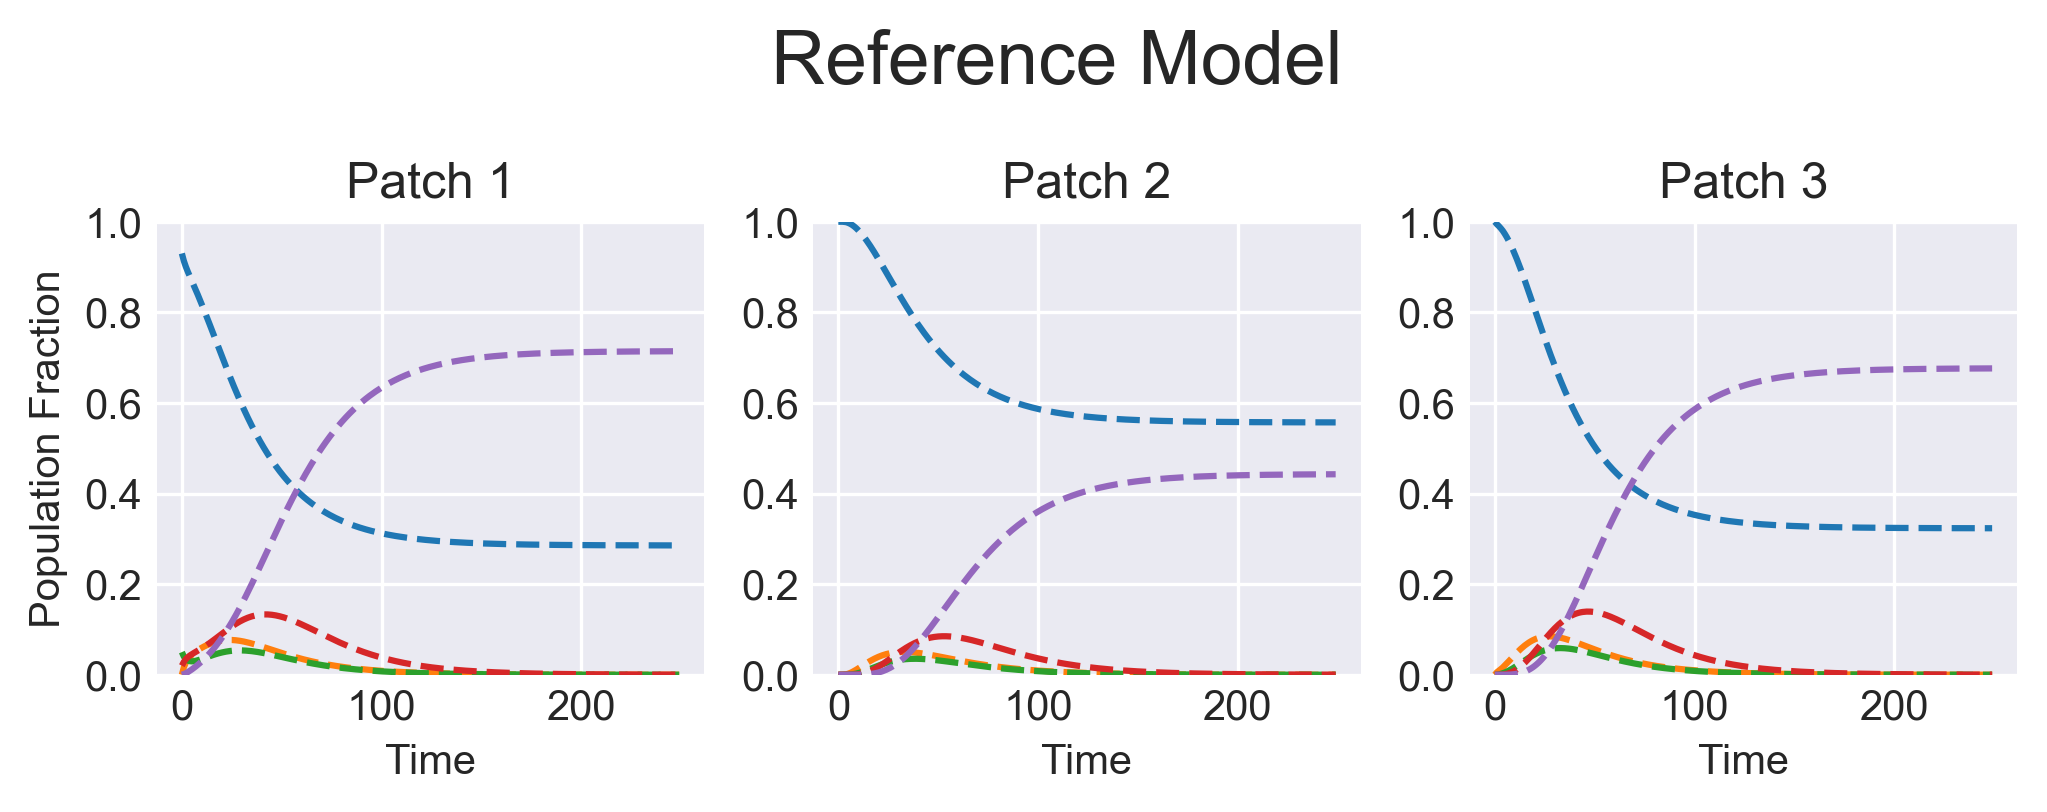

(3, 4)


In [6]:
fig, axs = plt.subplots(nrows=1, ncols=M, figsize=(8,2), dpi =300)
fig.suptitle('Reference Model', y = 1.2, fontsize = 18)
for i in range (M):
    plt.setp(axs[i], xlabel='Time', title = 'Patch {}'.format(i+1), ylim =[0, 1])
    axs[i].plot(ref_traj[:,i],linestyle='--')
axs[0].set_ylabel('Population Fraction')
plt.show()
# print (tf.reduce_sum(ref_traj[:,0,:],axis=-1))
print (start.shape)

## Restraints

In [7]:
npoints = 5
np.random.seed(0)
# prior = maxentep.EmptyPrior()
prior = maxentep.Laplace(0.01)
restrained_compartments = [3] #(infected patch)
restrained_compartments_names = [full_compartments[m] for m in restrained_compartments]
number_of_restrained_compartments = len(restrained_compartments) 
# restrained_patches = np.random.choice(M, number_of_restrained_patches, replace=False)
restrained_patches = np.array([0])
print ('Patches restrained:', restrained_patches)
print ('Total number of restraints: ', npoints*number_of_restrained_compartments*len(restrained_patches))
print ('Compartments restrained: ', restrained_compartments_names)
restraints, plot_fxns_list, restraints_dict = maxentep.compartment_restrainer(restrained_patches, restrained_compartments, npoints, ref_traj, prior, noise=0.05, start_time= 0, end_time = 100)

Patches restrained: [0]
Total number of restraints:  5
Compartments restrained:  ['I']
Restraints are set on this time range: [0, 100]
59 0.11300838 0.10784743734654037
45 0.13207568 0.15260560737936643
31 0.121692084 0.12889426233404105
80 0.06942841 0.1421420820039372
17 0.08018887 0.11824075668734235


## abc


In [29]:
start_infected = 0.01
start_asymptomatic = 0.02
E_time = 5
A_time = 2
I_time = 10


abc_param_keys = ['start_infected', 'start_asymptomatic', 'E_time', 'A_time', 'I_time']
abc_param_values = [ start_infected, start_asymptomatic, E_time, A_time, I_time ] 
abc_parameters = dict(zip(abc_param_keys, abc_param_values))

def metapop_wraper(start_infected, start_asymptomatic, E_time, A_time, I_time):
    beta = 0.025
    start = np.zeros((3,4))
    start[0,2] = start_infected
    start[0,1] = start_asymptomatic
    compartments = ['E', 'A', 'I', 'R']
    infections_compartments = [1,2]
    tmat = maxentep.TransitionMatrix(compartments, infections_compartments)
    tmat.add_transition('E', 'A', E_time, 5)
    tmat.add_transition('A', 'I', A_time, 5)
    tmat.add_transition('I', 'R', I_time, 5)
    infect_fxn_abc = maxentep.contact_infection_func(infections_compartments)
    timesteps = 250
    meta_model = maxentep.MetaModel(infect_fxn_abc, timesteps, populations=population_fraction)
    trajectory = meta_model(R_norm, tmat.value, start, beta)[0]
    return trajectory
    

def abc_model(parameter):
#     E_time, A_time, I_time =float(parameter['E_time']), \
#                             + float(parameter['A_time']), float(parameter['I_time'])
#     start = np.zeros((3,4))
#     start[0,2] = float(parameter['start_infected'])
#     start[0,1] = float(parameter['start_asymptomatic'])
#     compartments = ['E', 'A', 'I', 'R']
#     infections_compartments = [1,2]
#     tmat = maxentep.TransitionMatrix(compartments, infections_compartments)
#     tmat.add_transition('E', 'A', E_time, 3)
#     tmat.add_transition('A', 'I', A_time, 3)
#     tmat.add_transition('I', 'R', I_time, 4)
#     infect_fxn_abc = maxentep.contact_infection_func(infections_compartments)
#     timesteps = 250
#     meta_model = maxentep.MetaModel(infect_fxn_abc, timesteps, populations=population_fraction)
#     trajectory = meta_model(R_norm, tmat.value, start, beta)[0]
    trajectory = metapop_wraper(float(parameter['start_infected']), float(parameter['start_asymptomatic']), \
                               + float(parameter['E_time']), float(parameter['A_time']), float(parameter['I_time'])  )
    restrainted_time_values = [59, 45, 31, 80, 17]
    values = np.array([trajectory[m,0,3].numpy() for m in restrainted_time_values])
    return {'data': values}

def distance(x, y):
    d = np.sum(np.abs(x['data'] - y['data']))
    return(d)
abc_result = abc_model(abc_parameters)

In [9]:
# 59 0.11300838 0.10784743734654037
# 45 0.13207568 0.15260560737936643
# 31 0.121692084 0.12889426233404105
# 80 0.06942841 0.1421420820039372
# 17 0.08018887 0.11824075668734235


# R_norm, start, beta, E_time, A_time, I_time 
parameter_priors = pyabc.Distribution(# R_norm=pyabc.RV("norm", sbi_param_values[0], 1), 
#                                 start=pyabc.RV("norm", sbi_param_values[0], 0.01),
                                start_infected=pyabc.RV("norm", abc_param_values[0], 0.01),
                                start_asymptomatic=pyabc.RV("norm", abc_param_values[1], 0.01),
                                E_time=pyabc.RV("norm", abc_param_values[2], 5),
                                A_time=pyabc.RV("norm", abc_param_values[3], 5),
                                I_time=pyabc.RV("norm", abc_param_values[4], 5))

print(parameter_priors )

<Distribution 'A_time', 'E_time', 'I_time', 'start_asymptomatic', 'start_infected'>


In [10]:
abc = pyabc.ABCSMC(abc_model, parameter_priors, distance)
db_path = 'sqlite:///' + os.path.join(os.getcwd(), 'abc_gravitation.db') 
observation = np.array([r.target for r in restraints])
abc.new(db_path, {'data': observation})
# x_1 = np.array([0.009231301, 0.028030522, 0.08351496, 0.0017322148, 0.22831888])
# x_2 = np.array([0.10784743734654037, 0.15260560737936643, 0.12889426233404105, 0.1421420820039372, 0.11824075668734235])
# print(distance(x_1,x_2))
print (observation)


INFO:History:Start <ABCSMC(id=16, start_time=2020-10-01 17:33:04.123867, end_time=None)>


[0.10784744 0.15260561 0.12889426 0.14214208 0.11824076]


In [11]:
import logging
tf.get_logger().setLevel(logging.ERROR)
history = abc.run(minimum_epsilon=0.1, max_nr_populations=5)

INFO:ABC:Calibration sample before t=0.
INFO:Epsilon:initial epsilon is 0.6437599203207535
INFO:ABC:t: 0, eps: 0.6437599203207535.
INFO:ABC:Acceptance rate: 100 / 170 = 5.8824e-01, ESS=1.0000e+02.
INFO:ABC:t: 1, eps: 0.34683147846414586.
INFO:ABC:Acceptance rate: 100 / 230 = 4.3478e-01, ESS=5.8352e+01.
INFO:ABC:t: 2, eps: 0.2368124042798906.
INFO:ABC:Acceptance rate: 100 / 247 = 4.0486e-01, ESS=2.6827e+01.
INFO:ABC:t: 3, eps: 0.18478944756513724.
INFO:ABC:Acceptance rate: 100 / 255 = 3.9216e-01, ESS=6.2408e+01.
INFO:ABC:t: 4, eps: 0.15914742024205103.
INFO:ABC:Acceptance rate: 100 / 277 = 3.6101e-01, ESS=5.0341e+01.
INFO:History:Done <ABCSMC(id=16, start_time=2020-10-01 17:33:04.123867, end_time=2020-10-01 17:44:22.866725)>


In [41]:
df, w_abc = history.get_distribution(m=0, t=history.max_t)
abc_trajs=np.empty((len(df), ref_traj.shape[0], ref_traj.shape[1], ref_traj.shape[2]))
for i, row in enumerate(tqdm(np.array(df))):
    A_time, E_time_abc, I_time_abc, start_asymptomatic_abc, start_infected_abc= row[0], row[1], row[2], row[3], row[4]
    traj = metapop_wraper(start_infected_abc, start_asymptomatic_abc, E_time_abc,A_time_abc, I_time_abc)
    abc_trajs[i] = traj

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:50<00:00,  1.97it/s]


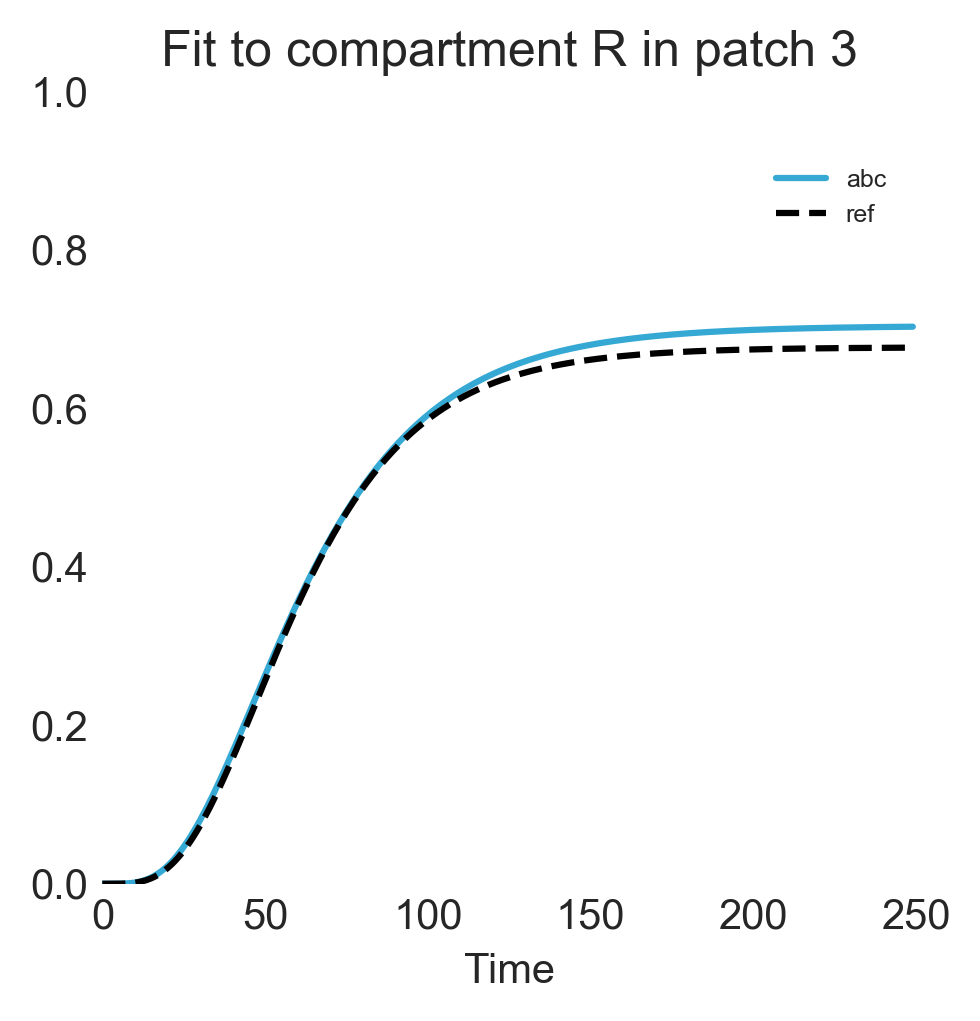

In [47]:
mean_abc_traj = np.sum(abc_trajs * w_abc[:, np.newaxis, np.newaxis, np.newaxis], axis = 0)
fig, axs = plt.subplots( figsize=(3.5,3.5), dpi =300)
plt.setp(plt.gca(), xlabel='Time', title='Fit to compartment R in patch 3', xlim =[0, 250], ylim =[0, 1.0], facecolor ='white' )
plt.plot(mean_abc_traj[:,2,4], color= '#35a9d4', label='abc')
plt.plot(ref_traj[:,2,4],linestyle='--', color= 'k', label='ref')
plt.legend(bbox_to_anchor=(0.8,0.8), fontsize=6)
np.save('mean_abc_traj',mean_abc_traj)